# Plots the results of the subsystems enrichment analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os 

## Define the colours

In [18]:
myColors = ((53/255, 96/255, 149/255, 1.0), (1.0, 1.0, 1.0, 1.0), (167/255, 56/255, 44/255, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
#cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light")


#sns.heatmap(df2[['Cyp51_19w_M', 'Cyp51_19w_M_F','Glmp_8w','Glmp_18w']], cmap = "RdBu_r", yticklabels=True)

## Function for plotting

In [19]:
def make_plot(df, enrichment_folder, file_name):
    ax1 = sns.heatmap(df, 
                cmap=cmap, 
                vmin=-1,
                vmax=1,
                yticklabels=True, 
                cbar=False,
                #cbar_kws={'ticks': [-1, 0, 1], 'tickslabels':['down-regulated', 'unchanged', 'up-regulated']},
                linewidths = 2)
    #cbar = ax1.figure.colorbar(ax1.collections[0])
    #cbar.set_ticks([-1, 0, 1])
    #cbar.set_ticklabels(['down-regulated', 'unchanged', 'up-regulated'])

    

    ax1.xaxis.set_ticks_position('top')

    #for item in ax1.get_yticklabels():
    #    item.set_rotation(30)

    for item in ax1.get_xticklabels():
        item.set_rotation(90)
    
    fig = plt.gcf()
    x,y = fig.get_size_inches()
    
    fig.set_size_inches(x,(df.shape[0]/90)*20)
    
    ax1.set_ylabel("")
    
    plt.savefig(enrichment_folder+'\\'+file_name+'.pdf', bbox_inches = 'tight')  
    plt.show()
    
    
    ax2 = sns.clustermap(df, 
                cmap=cmap, 
                vmin=-1,
                vmax=1,
                yticklabels=True, 
                cbar=False,
                #cbar_kws={'ticks': [-1, 0, 1], 'tickslabels':['down-regulated', 'unchanged', 'up-regulated']},
                linewidths = 2)
    #cbar = ax1.figure.colorbar(ax1.collections[0])
    #cbar.set_ticks([-1, 0, 1])
    #cbar.set_ticklabels(['down-regulated', 'unchanged', 'up-regulated'])    
    fig = plt.gcf()
    x,y = fig.get_size_inches()
    
    fig.set_size_inches(x,(df.shape[0]/90)*20)
    
    ax3 = ax2.ax_heatmap
    ax3.set_ylabel("")
    
    ax2.cax.set_visible(False)
    
    plt.savefig(enrichment_folder+'\\cluster_'+file_name+'.pdf', bbox_inches = 'tight') 
    plt.show()
    

# Settings

Folders, labels, etc.

In [20]:
enrichment_folder = 'results_enrichment_subsystems'
results_folder = 'results_enrichment'

In [21]:
MEM_labels = {"INIT":"INIT", "TINIT":"tINIT", "GIMME":"GIMME", "IMAT":"iMAT"}
dataset_labels = {'HBE':'HBE', 'LUNG':'Lung', '293T':'293T', 'CALU-3':'Calu-3', 'A549':'A549'}

order = {'MEM': ['iMAT', 'GIMME', 'INIT', 'tINIT'],
         'infection': ['healthy', 'infected'],
         'dataset': ['HBE', 'Lung', '293T', 'Calu-3', 'A549']}

# Preprocessing

In [22]:
columns = ['experiment', 'MEM', 'dataset', 'subsystem', 'enrichment']
df = pd.DataFrame(columns=columns)

file_names = [file_name for file_name in os.listdir(enrichment_folder) if file_name.endswith('csv')]
for file in file_names:
    experiment = os.path.splitext(file)[0]
    
    MEM = experiment.split("_")[0]
    MEM = MEM_labels[MEM.upper()]
    
    dataset = experiment.split("_")[1]
    dataset = dataset_labels[dataset.upper()]
    
    df_tmp = pd.read_csv(enrichment_folder+"\\"+file)
    #df_tmp.columns = ['subsystem', '_', '_', '_', 'up', 'down']#, 'p1', 'p2']    
    #df_tmp['enrichment'] = df_tmp['up'] - df_tmp['down']
    df_tmp = df_tmp[['subsystem', 'enrichment']]
    df_tmp['MEM'] = MEM
    df_tmp['dataset'] = dataset
    df_tmp['experiment'] = df_tmp['MEM']+"-"+df_tmp['dataset']
    
    df = df.append(df_tmp, ignore_index=True, sort=False)

#df = df.dropna()

# Plot datasets 
Common metabolic subsystems between datasets (Figure 4). 

Different numbers of minimal number of commonly up- or down-regulated subsystems are used (`min_common`) - all have to go in a same direction!

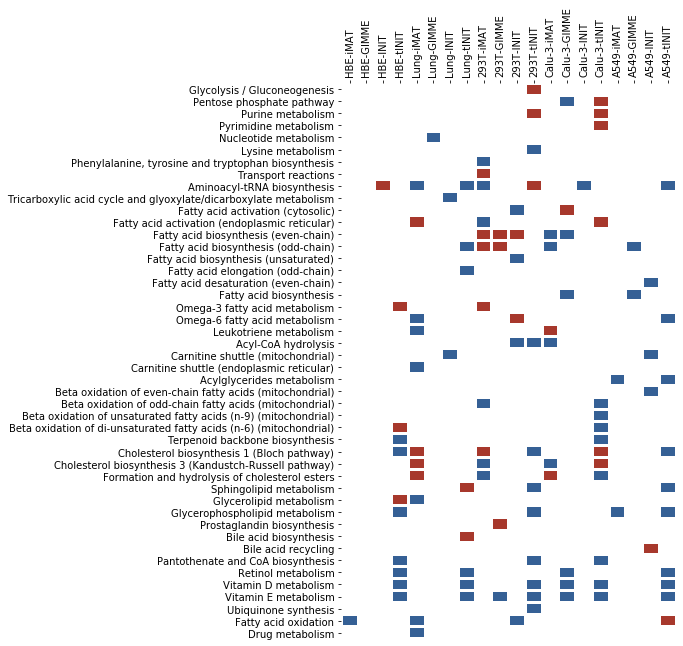

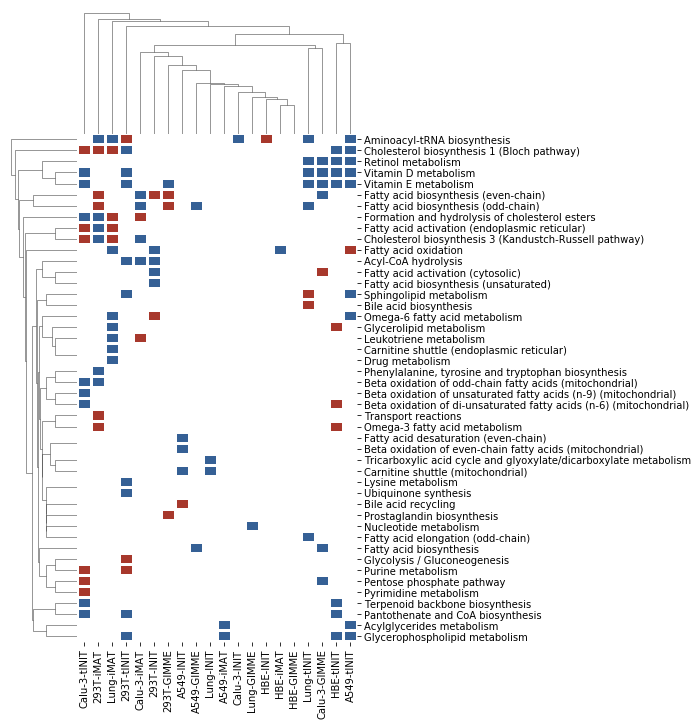

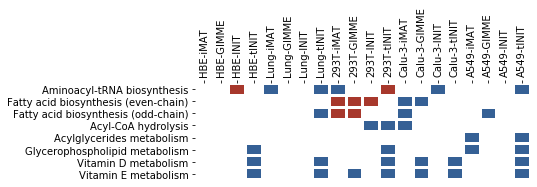

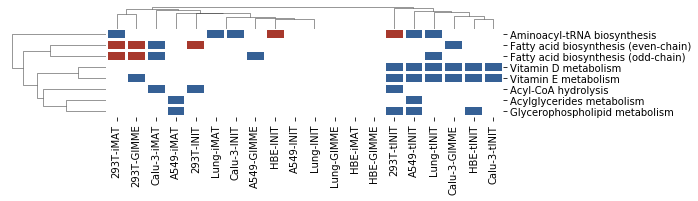

In [23]:
#min_common = 2 #minimal enriched MEMs for a subsystem
for min_common in range(1,3): # minimal enriched MEMs for a subsystem
    df_enrich = pd.DataFrame(columns=['subsystem'])

    subsystems = set()
    for dataset in order['dataset']:


        df2 = df[df['dataset'] == dataset]
        df_enrich_dataset = pd.DataFrame(columns=['subsystem'])
        for MEM in order['MEM']:
            df_tmp = df2[df2['MEM'] == MEM]
            df_tmp = df_tmp[['subsystem', 'enrichment']]
            df_tmp.columns = ['subsystem', dataset+'-'+MEM]

            df_enrich_dataset = df_enrich_dataset.merge(df_tmp, on='subsystem', how='outer')

        up = np.sum((df_enrich_dataset[df_enrich_dataset.columns[1:]] == 1).values, axis=1)
        down = np.sum((df_enrich_dataset[df_enrich_dataset.columns[1:]] == -1).values, axis=1)
        common = np.array([up, down])
        df_enrich_dataset['common'] = np.max(common, axis=0)
        subsystems |= set(df_enrich_dataset[df_enrich_dataset['common'] >= min_common].subsystem)
        #df_enrich_dataset = df_enrich_dataset[df_enrich_dataset['common'] >= min_common]
        df_enrich_dataset = df_enrich_dataset.drop(columns=['common'])

        df_enrich = df_enrich.merge(df_enrich_dataset, on='subsystem', how='outer')

    df_enrich = df_enrich.fillna(0)
    df_enrich = df_enrich[df_enrich.subsystem.isin(subsystems)]

    df_enrich = df_enrich.set_index("subsystem")
    make_plot(df_enrich, "results_enrichment", "datasets_unique_"+str(min_common))

# Plot MEMs
Common metabolic subsystems between model extraction methods (Figure 5)

Different numbers of minimal number of commonly up- or down-regulated subsystems are used (`min_common`) - all have to go in a same direction!

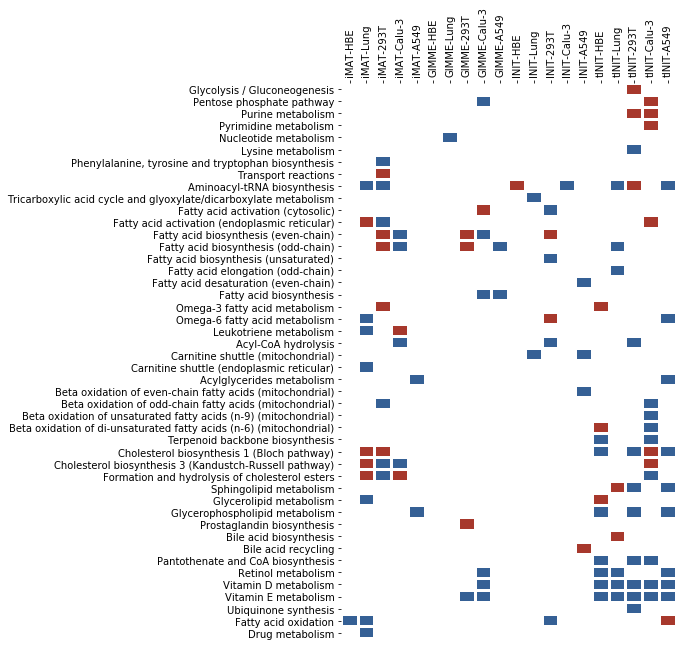

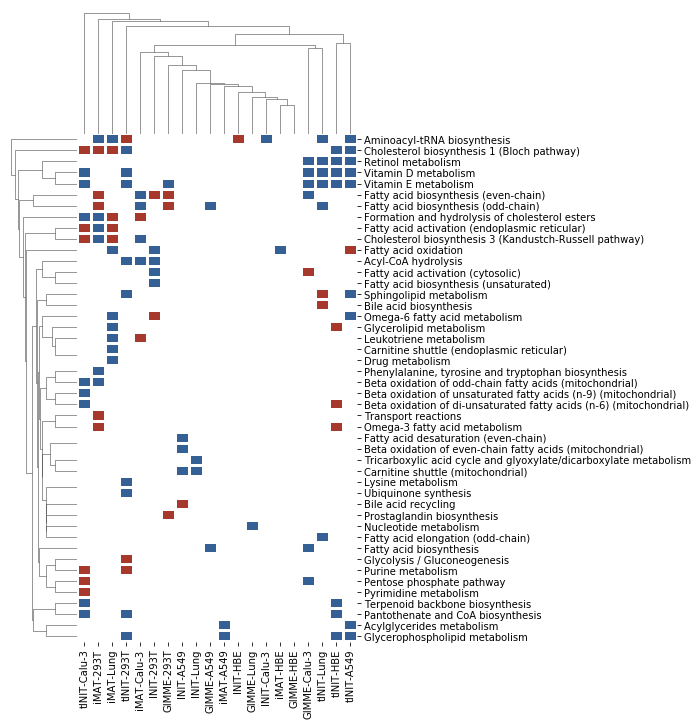

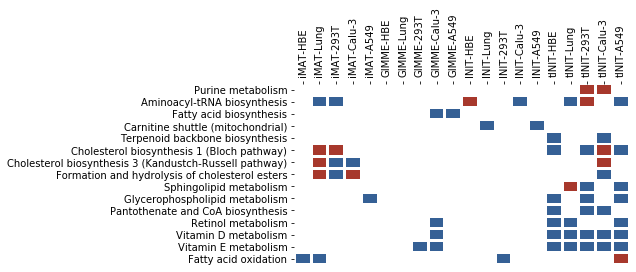

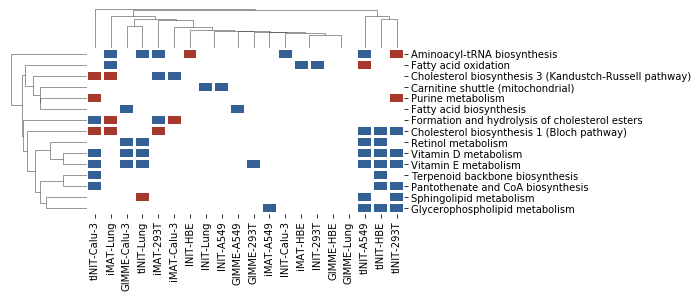

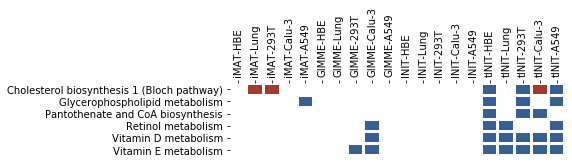

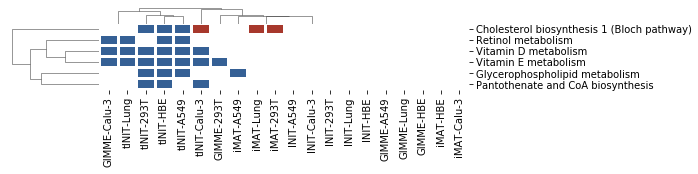

In [24]:
#min_common = 4 # minimal enriched datasets for a subsystem
for min_common in range(1,4): # minimal enriched datasets for a subsystem
    df_enrich = pd.DataFrame(columns=['subsystem'])

    subsystems = set()
    for MEM in order['MEM']:

        df2 = df[df['MEM'] == MEM]
        df_enrich_MEM = pd.DataFrame(columns=['subsystem'])
        for dataset in order['dataset']:
            df_tmp = df2[df2['dataset'] == dataset]
            df_tmp = df_tmp[['subsystem', 'enrichment']]
            df_tmp.columns = ['subsystem', MEM+"-"+dataset]

            df_enrich_MEM = df_enrich_MEM.merge(df_tmp, on='subsystem', how='outer')


        up = np.sum((df_enrich_MEM[df_enrich_MEM.columns[1:]] == 1).values, axis=1)
        down = np.sum((df_enrich_MEM[df_enrich_MEM.columns[1:]] == -1).values, axis=1)
        common = np.array([up, down])
        df_enrich_MEM['common'] = np.max(common, axis=0)        
        #df_enrich_MEM = df_enrich_MEM[df_enrich_MEM['common'] >= min_common]
        subsystems |= set(df_enrich_MEM[df_enrich_MEM['common'] >= min_common].subsystem)
        df_enrich_MEM = df_enrich_MEM.drop(columns=['common'])

        df_enrich = df_enrich.merge(df_enrich_MEM, on='subsystem', how='outer')

    df_enrich = df_enrich.fillna(0)
    df_enrich = df_enrich[df_enrich.subsystem.isin(subsystems)]

    df_enrich = df_enrich.set_index("subsystem")
    df_enrich.head()

    make_plot(df_enrich, "results_enrichment", "MEMs_unique_"+str(min_common))

Not used in the paper...

# Plot MEMs (non-unique)
Common metabolic subsystems between model extraction methods

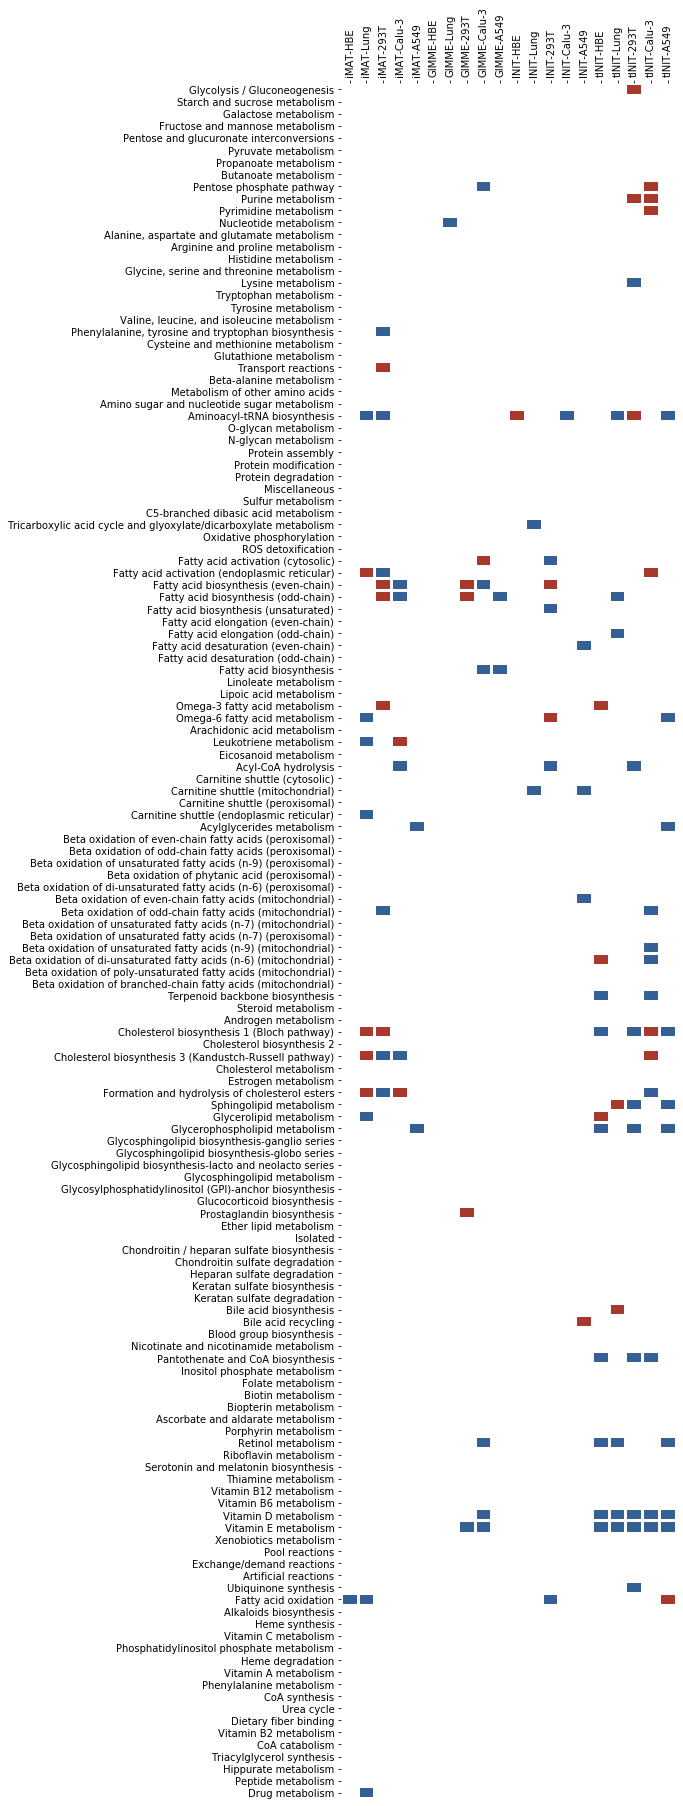

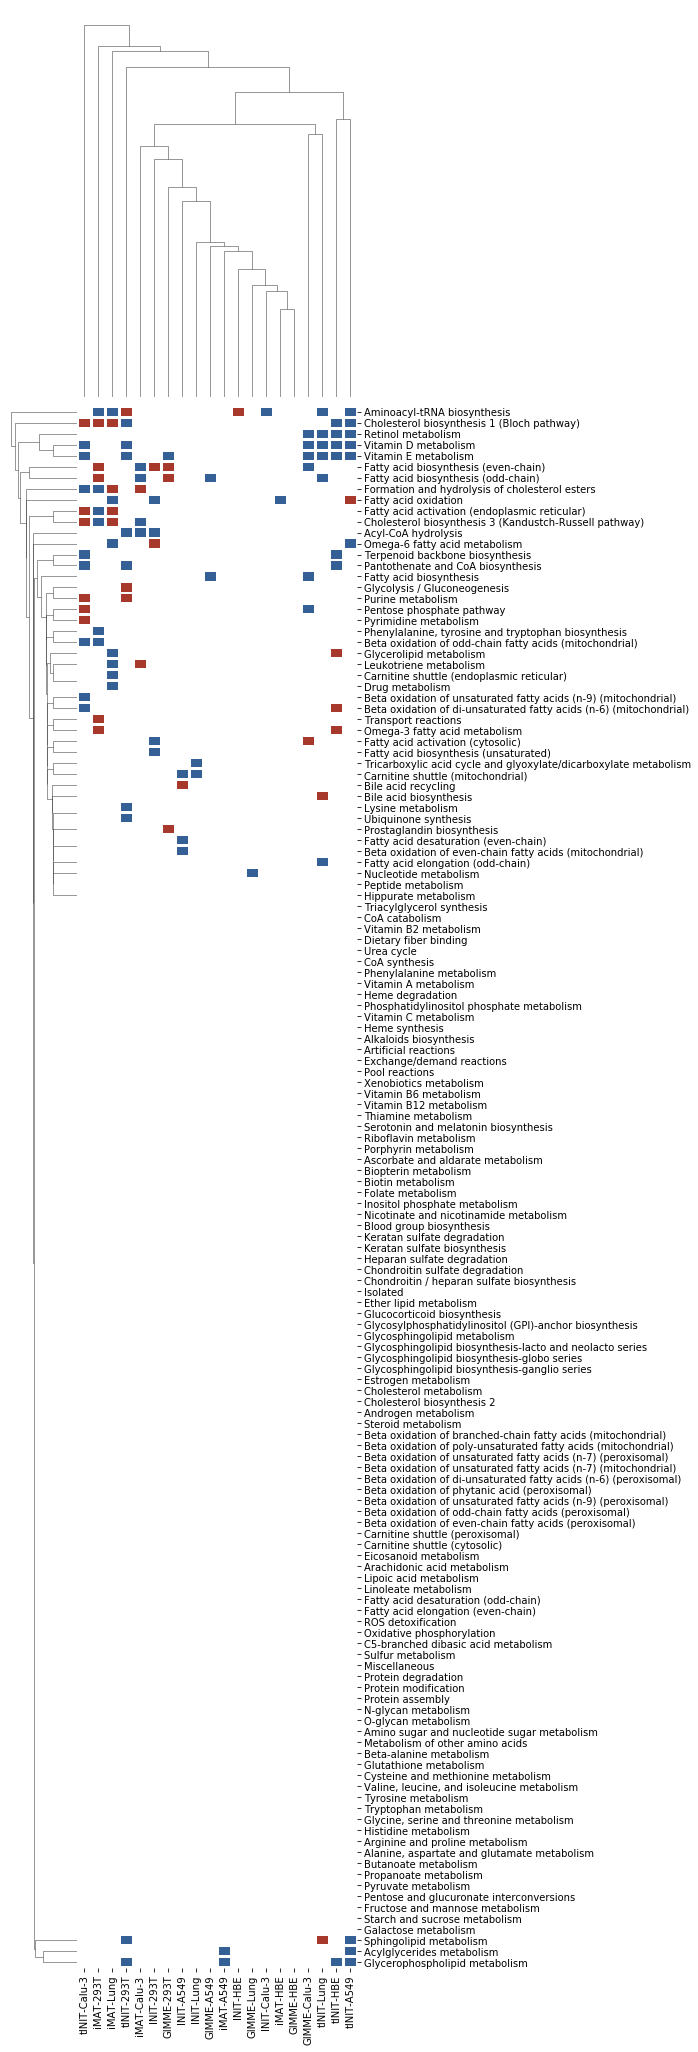

In [17]:
for min_common in range(1): # minimal enriched datasets for a subsystem
    df_enrich = pd.DataFrame(columns=['subsystem'])

    subsystems = set()

    for MEM in order['MEM']:

        df2 = df[df['MEM'] == MEM]
        df_enrich_MEM = pd.DataFrame(columns=['subsystem'])
        for dataset in order['dataset']:
            df_tmp = df2[df2['dataset'] == dataset]
            df_tmp = df_tmp[['subsystem', 'enrichment']]
            df_tmp.columns = ['subsystem', MEM+"-"+dataset]

            df_enrich_MEM = df_enrich_MEM.merge(df_tmp, on='subsystem', how='outer')


        df_enrich_MEM['common'] = np.sum(np.abs(df_enrich_MEM[df_enrich_MEM.columns[1:]].values), axis=1)
        #df_enrich_MEM = df_enrich_MEM[df_enrich_MEM['common'] >= min_common]

        subsystems |= set(df_enrich_MEM[df_enrich_MEM['common'] >= min_common].subsystem)

        df_enrich_MEM = df_enrich_MEM.drop(columns=['common'])

        df_enrich = df_enrich.merge(df_enrich_MEM, on='subsystem', how='outer')

    df_enrich = df_enrich.fillna(0)
    df_enrich = df_enrich[df_enrich.subsystem.isin(subsystems)]

    df_enrich = df_enrich.set_index("subsystem")
    df_enrich.head()

    make_plot(df_enrich, "results_enrichment", "MEMs_"+str(min_common))

# Plot datasets (non-unique)
Common metabolic subsystems between datasets

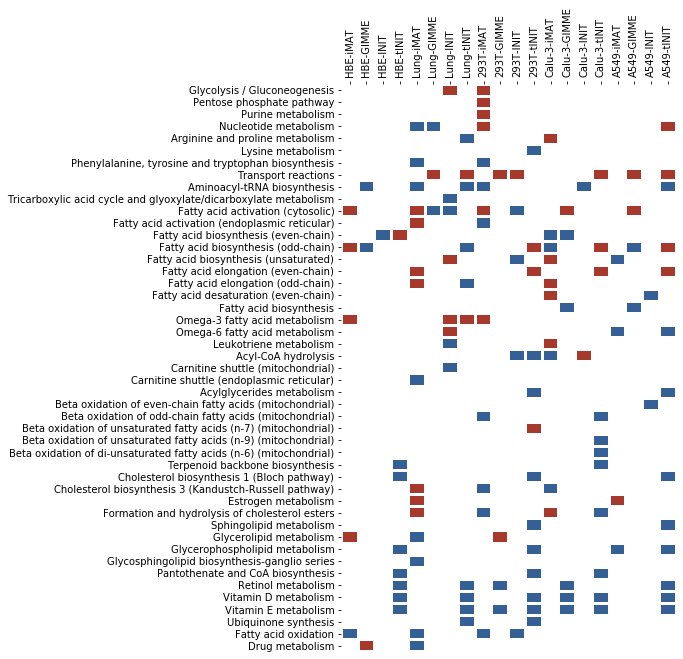

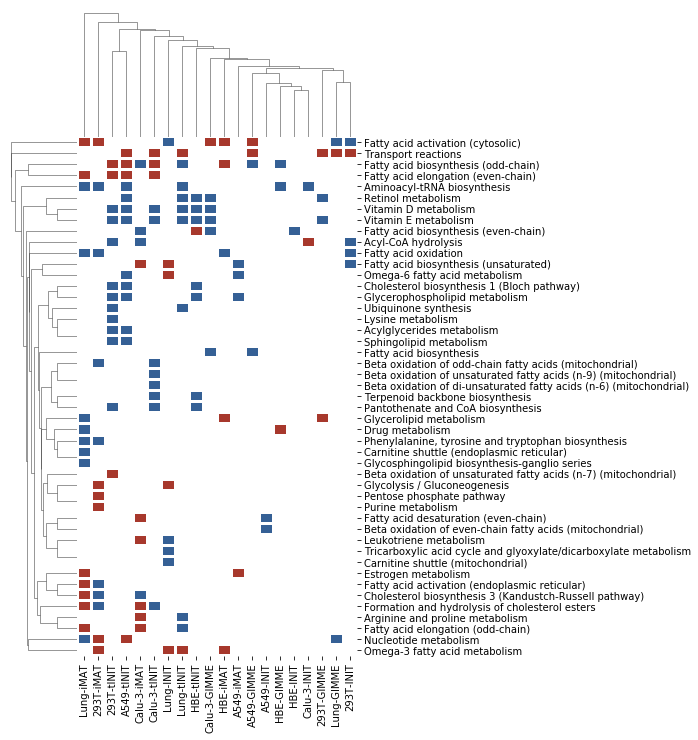

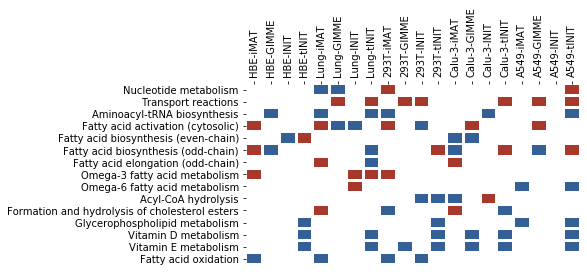

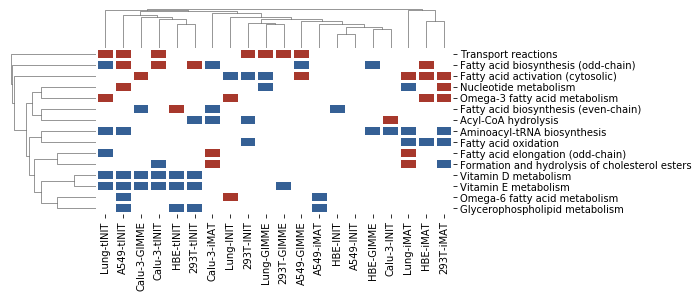

In [9]:
#min_common = 4 #minimal enriched MEMs for a subsystem
for min_common in range(1): # minimal enriched MEMs for a subsystem
    df_enrich = pd.DataFrame(columns=['subsystem'])

    subsystems = set()
    for dataset in order['dataset']:


        df2 = df[df['dataset'] == dataset]
        df_enrich_dataset = pd.DataFrame(columns=['subsystem'])
        for MEM in order['MEM']:
            df_tmp = df2[df2['MEM'] == MEM]
            df_tmp = df_tmp[['subsystem', 'enrichment']]
            df_tmp.columns = ['subsystem', dataset+'-'+MEM]

            df_enrich_dataset = df_enrich_dataset.merge(df_tmp, on='subsystem', how='outer')


        df_enrich_dataset['common'] = np.sum(np.abs(df_enrich_dataset[df_enrich_dataset.columns[1:]].values), axis=1)
        #df_enrich_dataset = df_enrich_dataset[df_enrich_dataset['common'] >= min_common]
        subsystems |= set(df_enrich_dataset[df_enrich_dataset['common'] >= min_common].subsystem)
        df_enrich_dataset = df_enrich_dataset.drop(columns=['common'])

        df_enrich = df_enrich.merge(df_enrich_dataset, on='subsystem', how='outer')

    df_enrich = df_enrich.fillna(0)
    df_enrich = df_enrich[df_enrich.subsystem.isin(subsystems)]

    df_enrich = df_enrich.set_index("subsystem")
    make_plot(df_enrich, "results_enrichment", "datasets_"+str(min_common))